In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

##Clustering##
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import (KMeans, AgglomerativeClustering)
from scipy.cluster.hierarchy import (dendrogram , cut_tree)
from ISLP.cluster import compute_linkage

# Clustering

Lets apply hirerical clustering and pca to the data and see if we can find the group of migrator starts by this approach. 

In [31]:
data = pd.read_csv('Faellesdata_cleaned.csv')
scaler = StandardScaler(with_std=True, with_mean=True)
isMigrator = data['IsMigratorInt']
data = data.drop(['IsMigratorInt'], axis=1)
data_scaled = scaler.fit_transform(data)

In [38]:
data

,z,vz,Rcyl,phi,vRcyl,vphi,age,mass,feh,oh,ch,mgh,ofe,cfe,mgfe
0,0.361,-92.909,1.236,341.267,-82.221,166.156,6.961,6600.002,-0.253,0.194,0.053,0.026,0.448,0.306,0.279
1,-0.162,24.089,1.525,300.646,42.443,257.005,1.891,5529.467,0.141,0.610,0.520,0.366,0.470,0.379,0.225
2,-0.369,-21.360,6.925,162.806,-85.396,283.916,0.963,8819.483,0.046,0.517,0.400,0.283,0.471,0.355,0.238
3,-0.330,-26.248,5.832,0.303,175.200,128.138,1.231,6918.149,0.129,0.596,0.503,0.351,0.466,0.374,0.222
4,-0.243,304.173,0.292,13.944,286.408,-28.238,8.985,6125.553,-0.536,-0.069,-0.262,-0.230,0.467,0.274,0.306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,0.123,22.456,0.705,307.465,12.126,179.076,5.120,10796.726,0.048,0.485,0.393,0.278,0.437,0.344,0.230
9995,0.024,-202.398,0.552,190.765,-15.763,-78.668,8.986,5159.025,-0.524,-0.061,-0.224,-0.221,0.463,0.300,0.304
9996,-0.151,-87.273,2.180,95.685,-217.565,75.266,8.757,4770.375,-0.543,-0.058,-0.271,-0.220,0.485,0.272,0.323
9997,-0.056,-104.503,0.356,211.362,-170.438,-44.733,5.870,5257.479,-0.085,0.356,0.227,0.170,0.442,0.312,0.255


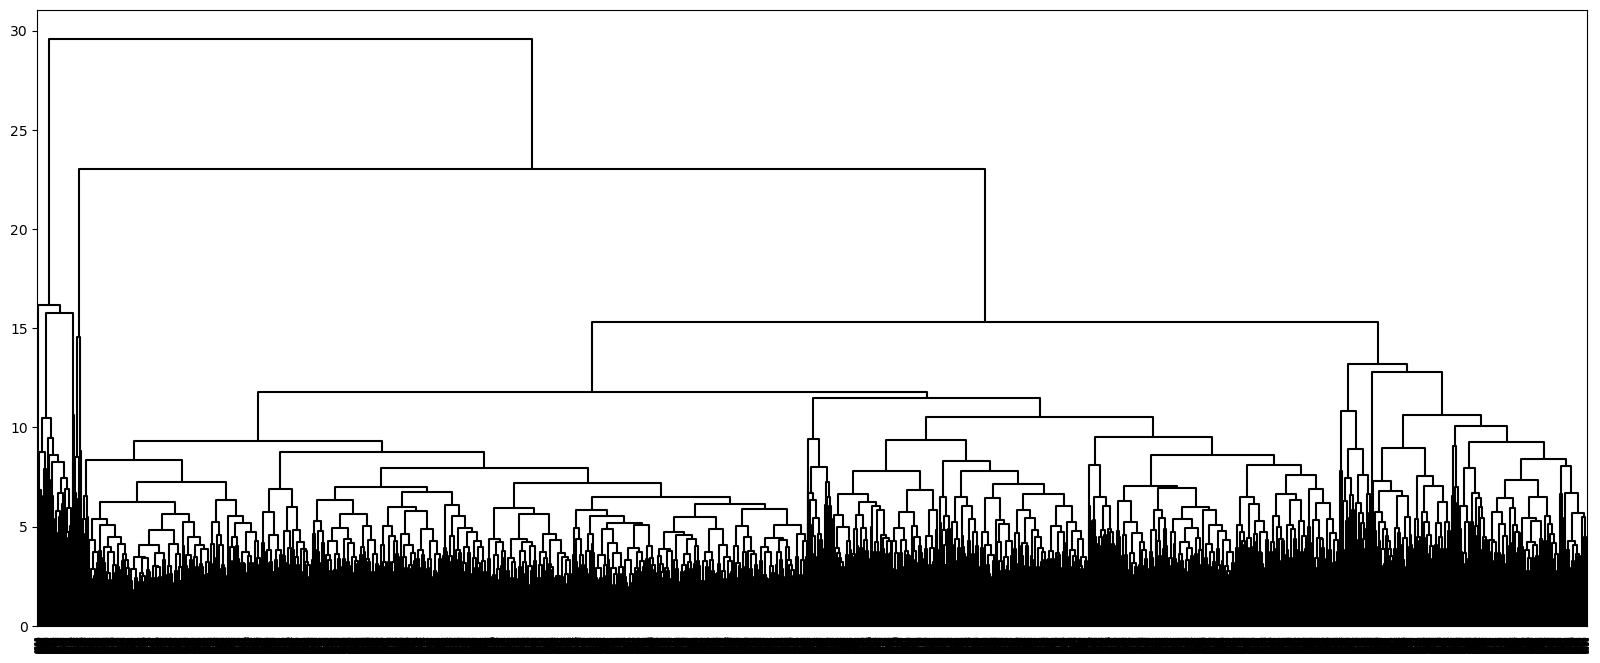

In [32]:
HClust = AgglomerativeClustering 
hc_comp = HClust(distance_threshold=0, n_clusters=None, linkage='complete')
hc_comp.fit(data_scaled)

cargs = {'color_threshold':-np.inf, 'above_threshold_color':'black'} #to avoid precoloring the dendrogram
linkage_comp = compute_linkage(hc_comp)
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
dendrogram(linkage_comp, ax=ax, **cargs);

Looking at this we cut at height 12 

In [33]:
height = 13
cluster_label = cut_tree(linkage_comp, height = height ).flatten()
np.unique(cluster_label)

array([0, 1, 2, 3, 4, 5, 6, 7])

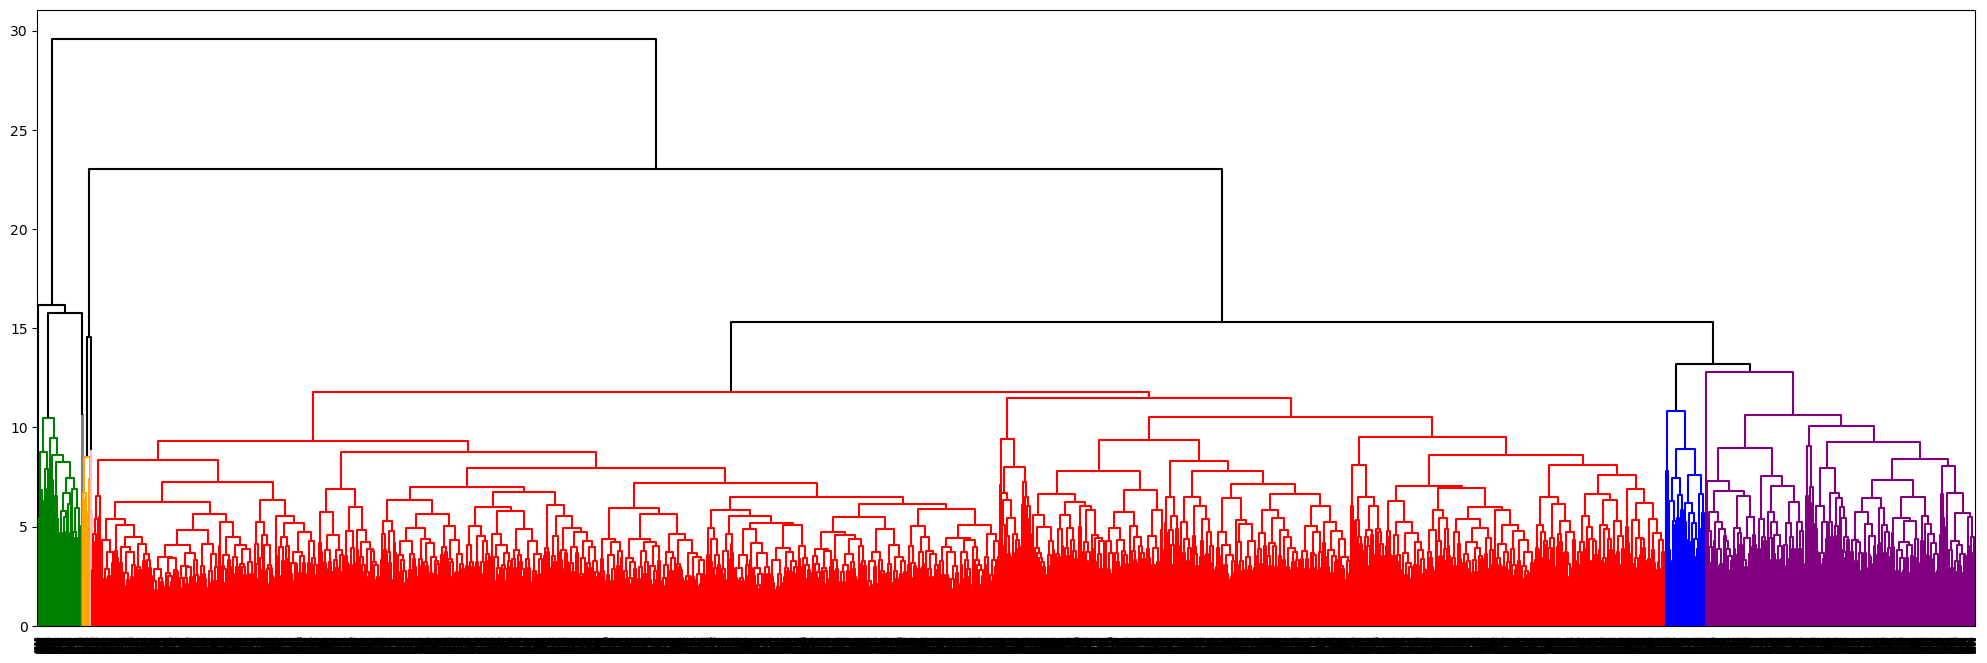

In [34]:
cluster_colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'pink', 'grey']
label_color_map = {i: cluster_colors[i] for i in range(len(cluster_colors))}

# Create a color function for the branches taken from homework 11 
def branch_color_func(linkage_comp, cluster_labels, num_leaves):
    """Generate a color function for the branches of the dendrogram based on cluster labels.
    Returns: A function to use as `link_color_func` in `dendrogram`"""
    # Create a dictionary to map node IDs to colors
    node_to_color = {}

    # Initialize leaf nodes with their cluster colors
    for i in range(num_leaves):
        node_to_color[i] = label_color_map[cluster_labels[i]]

    # Propagate colors upward through the hierarchy
    for i, (left, right, _, _) in enumerate(linkage_comp):
        node_id = i + num_leaves  # Non-leaf node ID
        left_color = node_to_color[int(left)]
        right_color = node_to_color[int(right)]

        # If both children have the same color, propagate it; otherwise, default to black
        if left_color == right_color:
            node_to_color[node_id] = left_color
        else:
            node_to_color[node_id] = 'black'

    # Define a function to return the color for a given node ID
    def color_func(node_id):
        return node_to_color[node_id]
    return color_func

# Generate the color function
link_color_func = branch_color_func(linkage_comp, cluster_label, len(cluster_label))

fig, ax = plt.subplots(1, 1, figsize=(25, 8))
dendrogram(linkage_comp, ax=ax, link_color_func = link_color_func)
plt.xticks(rotation=90)
plt.show()

We now use PCA on it too. 

In [36]:
pcaMigrator = PCA()
pcaMigrator.fit(data_scaled)

PCA()

The scores are the projections of each data point onto the principal components. So first column is PC1, next PC2 and so on. 

In [37]:
pcaMigrator.components_ # in this one it is stored according to the columns of the original data so the first row is for z next vz and so on and the rows are for the prinicipal components.
scores = pcaMigrator.transform(data_scaled)

In [83]:
#print the explained variance formatted nicely with only 3 decimals
print('Explained variance ratio:')
print('\n'.join([f'PC{i+1}: {var:.3f}' for i, var in enumerate(pcaMigrator.explained_variance_ratio_)]))

Explained variance ratio:
PC1: 0.461
PC2: 0.100
PC3: 0.069
PC4: 0.068
PC5: 0.066
PC6: 0.064
PC7: 0.057
PC8: 0.049
PC9: 0.041
PC10: 0.016
PC11: 0.009
PC12: 0.002
PC13: 0.000
PC14: 0.000
PC15: 0.000


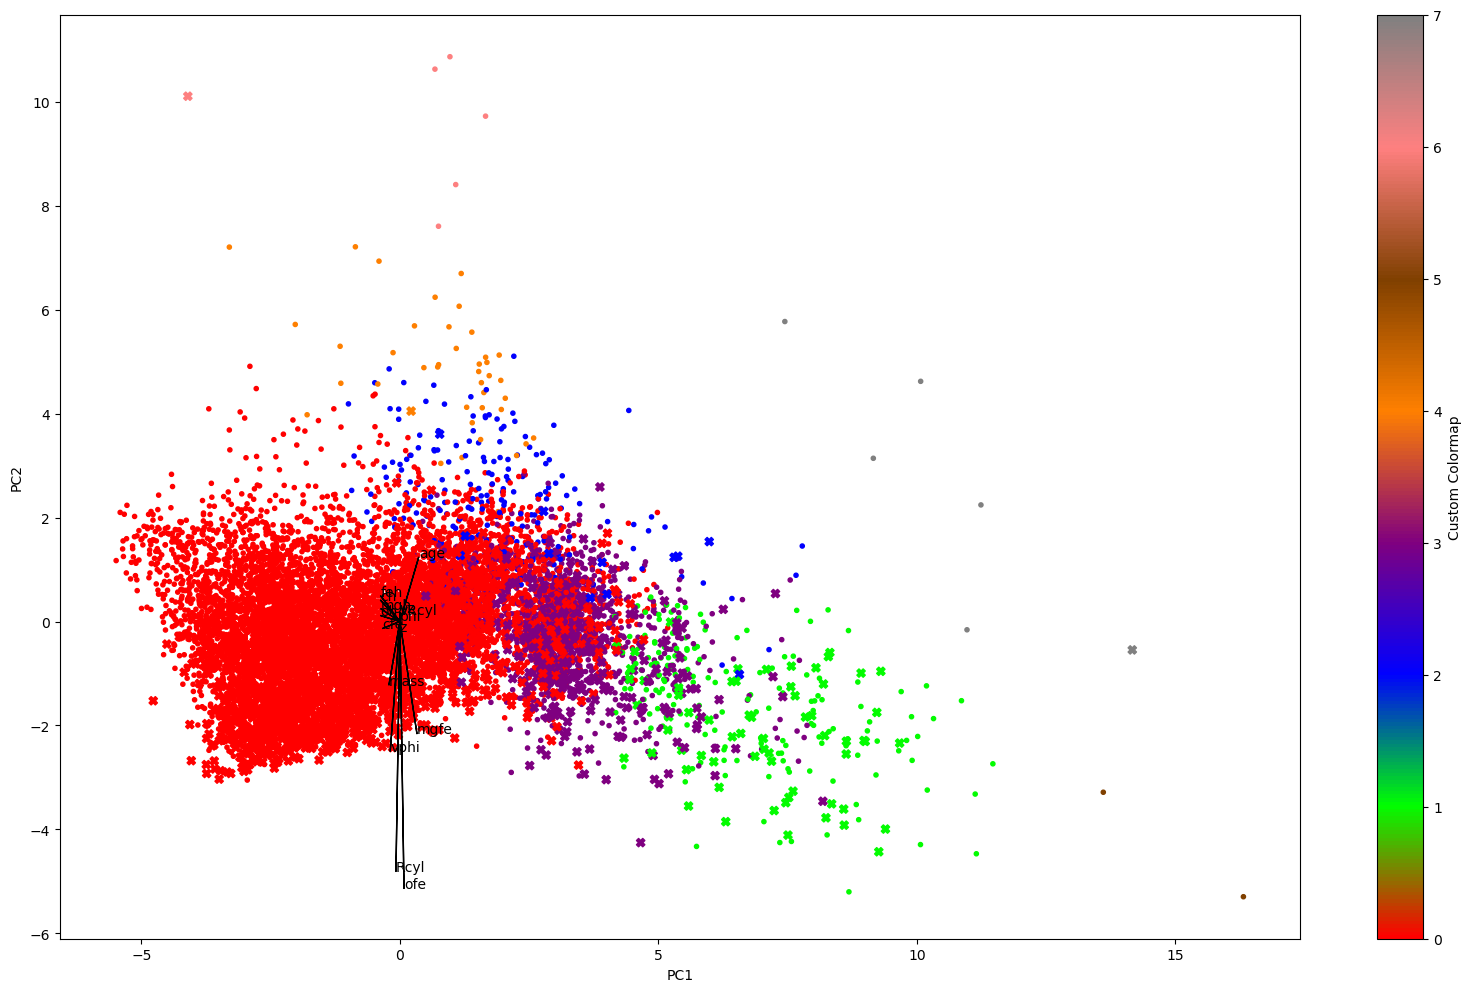

In [77]:
cale_arrow = s_ = 8
i, j = 0, 1 # which components

#color of clusters 
#make it so it maches  ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'pink', 'grey']
colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (0.5, 0, 0.5), (1, 0.5, 0), (0.5, 0.25, 0), (1, 0.5, 0.5), (0.5, 0.5, 0.5)] 
node_lin_space = np.linspace(0, 1, len(colors))
nodes = node_lin_space.tolist()  # Position of colors in the colormap (0=low, 1=high)

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(nodes, colors)))

fig, ax = plt.subplots(1, 1, figsize=(20, 12)) 

mask1 = isMigrator == 1
mask0 = isMigrator == 0


scatter0 = ax.scatter(scores[:,0][mask0], scores[:,1][mask0], marker = '.', c = cluster_label[mask0], cmap=custom_cmap)
scatter1 = ax.scatter(scores[:,0][mask1], scores[:,1][mask1], marker = 'X', c = cluster_label[mask1], cmap=custom_cmap) 


ax.set_xlabel('PC%d' % (i+1))  
ax.set_ylabel('PC%d' % (j+1))

#This part is for plotting the components ie murder, assult, urbanpop and rape. 
for k in range(pcaMigrator.components_.shape[1]):
    ax.arrow(0, 0, pcaMigrator.components_[i,k], s_ * pcaMigrator.components_[j,k]) 
    ax.text(pcaMigrator.components_[i,k], s_ * pcaMigrator.components_[j,k], 
            data.columns[k])


cbar0 = plt.colorbar(scatter0, ax=ax)
cbar0.set_label("Custom Colormap")

What groups have most migrator stars. 

array([0, 1, 2, 3, 4, 5, 6, 7])

In [128]:
#what cluster has most migrator stars
cluster_migrator_ratio = []


for k in (np.unique(cluster_label)):
    cluster_migrator = []
    cluster_index = np.where(cluster_label == k)[0]

    for i in cluster_index:
        cluster_migrator.append(isMigrator[i])

    cluster_ratio = np.sum(cluster_migrator)/len(cluster_migrator)    
    cluster_migrator_ratio.append(cluster_ratio)

print(cluster_migrator_ratio)

[0.18433690432212782, 0.28193832599118945, 0.057692307692307696, 0.14265129682997119, 0.024390243902439025, 0.0, 0.16666666666666666, 0.16666666666666666]


In [84]:
#get the index of cluster_label where the value equal 0. 
index_cluser_label = np.arg(cluster_label 


array([0, 0, 0, ..., 0, 0, 0])

In [93]:
x = np.array([1,2, 1, 1, 5, 6, ])
np.where(x == 1)[0]

array([0, 2, 3])